**Create Business Intelligence tool using Multi Agent Supervisor**

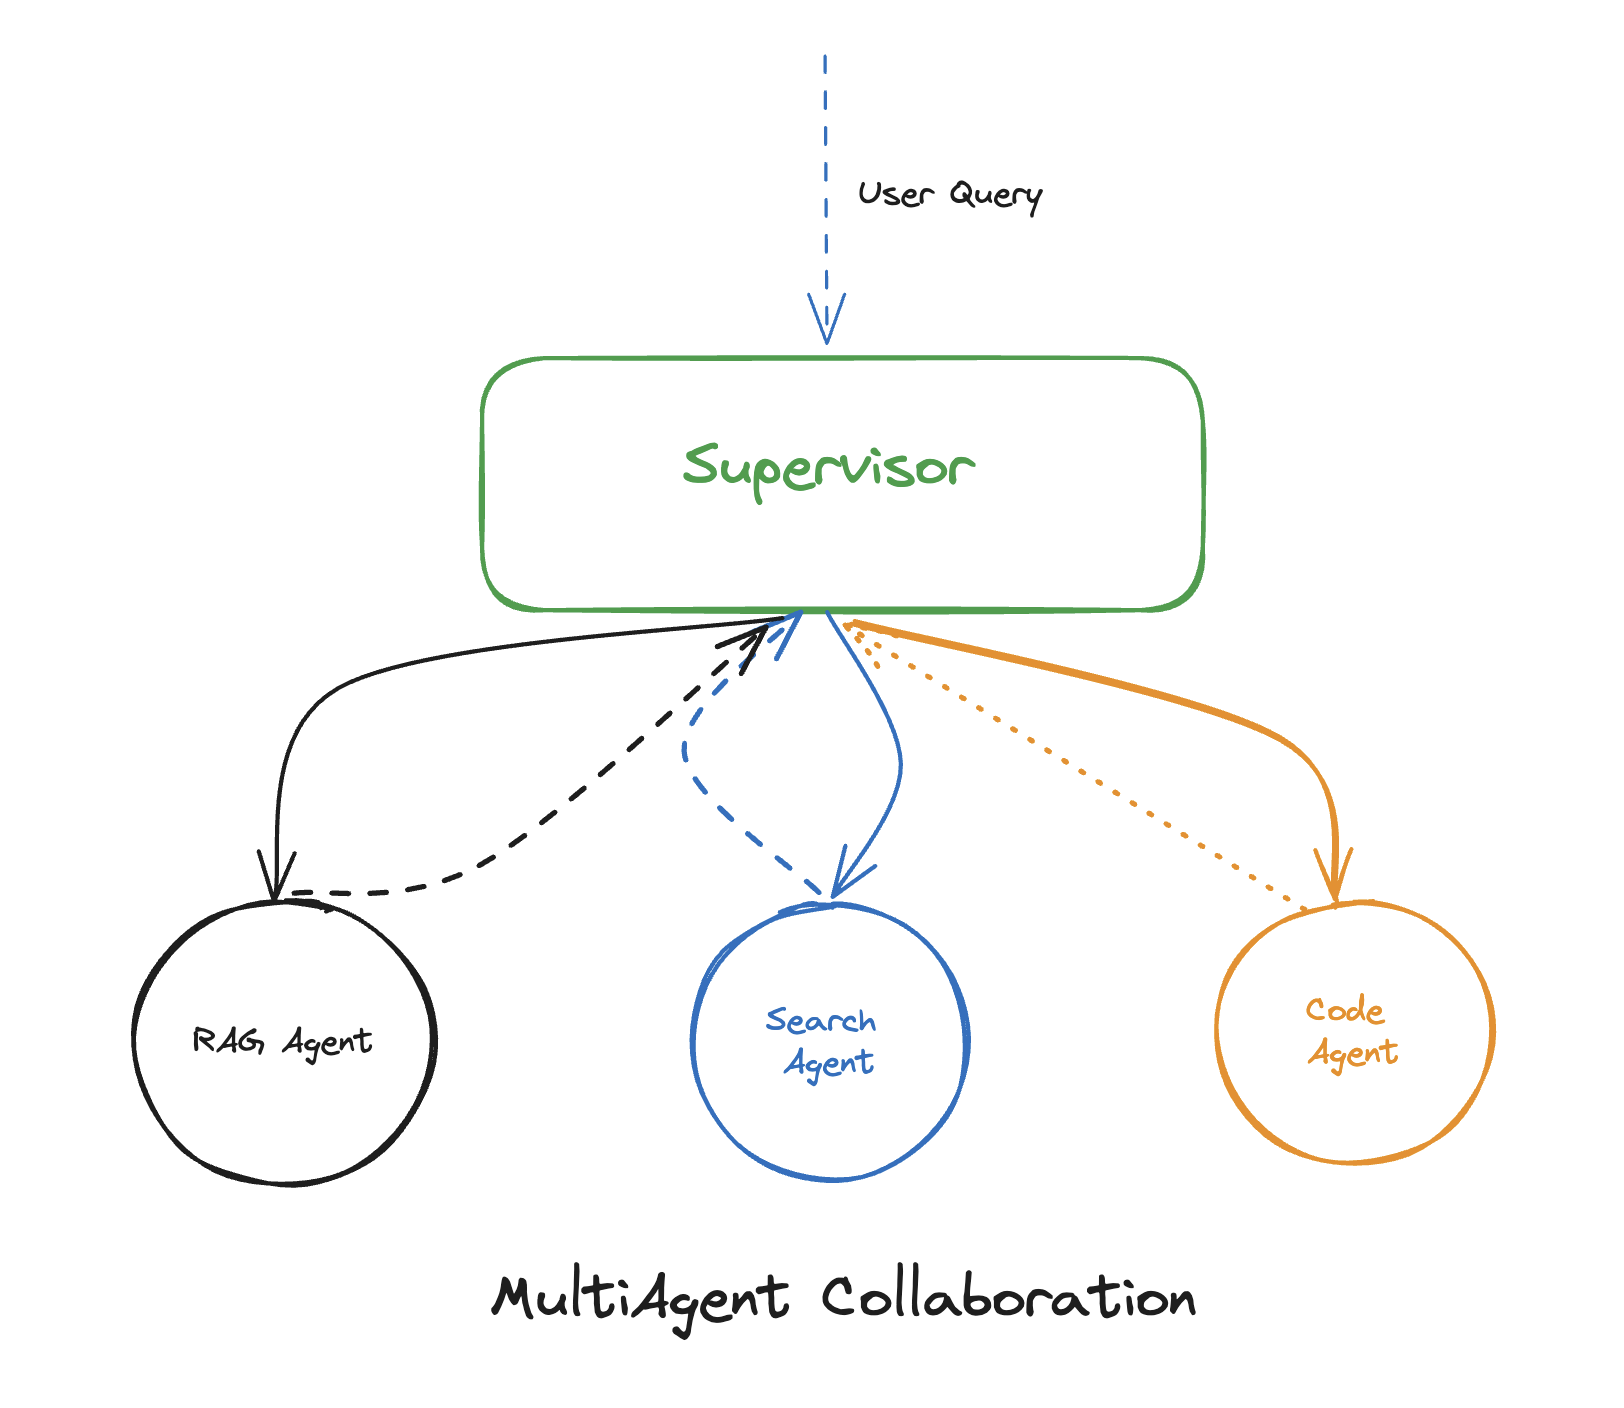

In [ ]:

from IPython.display import Image
Image(filename='/content/supervisor.png',width=800)

In [ ]:
!pip install langchain langchain_community

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your termin

In [3]:
from langchain_community.llms import HuggingFaceHub
from google.colab import userdata
hg_api =  userdata.get('hugginface_key')
llm =  HuggingFaceHub(repo_id="HuggingFaceH4/zephyr-7b-alpha",
                      model_kwargs={"temperature":0.6, "max_length":512},
                       huggingfacehub_api_token = hg_api # This parameter should be huggingfacehub_api_token
                      )

<ipython-input-3-2629cb1aec60>:4: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm =  HuggingFaceHub(repo_id="HuggingFaceH4/zephyr-7b-alpha",


## **Create agent function :**

In [4]:
from langchain.agents import AgentExecutor , create_openai_tools_agent
from langchain_core.messages import BaseMessage , HumanMessage

def create_agent(llm : llm  , tools : list , system_prompt  : str )  :
  prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
  agent = create_openai_tools_agent(llm, tools, prompt)
  executor = AgentExecutor(agent=agent, tools=tools)
  return executor

## **Creation of Tools :**

-  Tavilly Search Tools
- PythonREPLTool

In [ ]:
!pip install langchain_community
!pip install langchain_experimental # install the missing package

In [6]:
# prompt: setup tavilly api key , api key in my secrets

from google.colab import userdata
tavily_api_key = userdata.get('tavily_api_key')


In [7]:
import os
from google.colab import userdata

tavily_api_key = userdata.get('tavily_api_key')

if tavily_api_key:
  os.environ['TAVILY_API_KEY'] = tavily_api_key # Use the actual api key value instead of calling os.environ.get
else:
  print("Tavily API key not found in user data.")

In [8]:
from typing import Annotated , List , Tuple , Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

# The TavilySearchResults class expects the api key as  'api_key' not 'tavily_api_key'
tavily_tool = TavilySearchResults(api_key=tavily_api_key ,max_results=5)

python_repl_tool = PythonREPLTool()

In [11]:
!pip install pypdf
!pip install chromadb
!pip install sentence_transformers


## RAG setup with Vector DB

In [12]:
from langchain_community.document_loaders import TextLoader , DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
loader =  PyPDFLoader("/content/japan-2-8.pdf")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=10)
texts = text_splitter.split_documents(documents)

new_docs = text_splitter.split_documents(documents=texts)
doc_strings = [doc.page_content for doc in new_docs]
model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceEmbeddings()

### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

<ipython-input-12-bbcd4f3e2fbb>:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
<ipython-input-12-bbcd4f3e2fbb>:16: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hug

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

## RAG Tool : Python function -> tool

In [14]:
from langchain.prompts import PromptTemplate
def RAG(state) :
  print(" -> Calling RAG ->")
  question =  state
  print('Question:', question)
  template = """ Answer the question based only on the following context
  {context}

  Question: {question}
  """


  prompt_template = PromptTemplate(input_variables=["context", "question"], template=template)
  retrieval_chain =   {
    {"context" : retriever , "question" : RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
  }
  result =  retrieval_chain.invoke(question)
  return result

## Agent node  
- takes state , agent and name as input
- return as HumanMessage with name

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

## Supervisor Chain creation
Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

- Has access and information about it's members.

- members = ["RAG" , "Researcher", "Coder"]

- options = ["FINISH"] + members

- "Given the conversation above, who should act next?" " Or should we FINISH? -
Select one of: {options}"

- Router -> function_def

In [ ]:
!pip install --upgrade langchain
!pip install --upgrade langchain-experimental

In [ ]:
!pip install transformers

In [ ]:
# Install necessary libraries first
!pip install --upgrade langchain
!pip install --upgrade langchain-experimental
!pip install transformers torch

from langchain.output_parsers import JsonOutputParser

from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.llms.base import LLM

# Define the members of the system
members = ["RAG", "Researcher", "Coder"]

# Define the system prompt
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Use RAG tool when questions"
    " are related to Japan or of Sports category. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Define the options for routing
options = ["FINISH"] + members

# Define the function schema for routing tasks
function_def = {
    "name": "route",
    "description": "Select the next worker to act.",
    "parameters": {
        "type": "object",
        "properties": {
            "next": {
                "type": "string",
                "description": "The next worker to act or FINISH",
                "enum": options,  # Provide the available options here
            }
        },
        "required": ["next"],
    },
}

# Create the prompt template with messages and routing logic
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=", ".join(options), members=", ".join(members))


# Load Zephyr-7B model and tokenizer
model_name = "HuggingFaceH4/zephyr-7b-beta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Custom LLM class
class ZephyrLLM(LLM):
    def __init__(self):
        self.tokenizer = tokenizer
        self.model = model

    def _call(self, prompt, stop=None, max_tokens=100):
        input_ids = self.tokenizer(prompt, return_tensors="pt").input_ids
        outputs = self.model.generate(input_ids, max_length=max_tokens)
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

    @property
    def _identifying_params(self):
        return {"model_name": "Zephyr-7B"}

    @property
    def llm_type(self):
        return "custom"

# Instantiate the custom LLM
llm = ZephyrLLM()

# Create the supervisor chain by connecting the prompt, LLM, and output parser
supervisor_chain = LLMChain(
    llm=llm,
    prompt=prompt,
    output_parser=JsonOutputParser(),
)

# Example usage:
messages = [
    {"role": "user", "content": "Tell me about Japanese sports."},
]

# Run the supervisor chain with the messages
supervisor_response = supervisor_chain.run(messages=messages)
print(supervisor_response)


## Creation of workflow with below nodes
#### Agent ->> Node (functools.partial)

- Research Node
- Code Node
- RAG Node

In [ ]:
!pip install langgraph

In [45]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END



# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [ ]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools
from langgraph import agent_node
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

RAG_agent = create_agent(
    llm,
    [RAG],
    "Use this tools when questions are related to Japan or of Sports category.",
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_chain)

## Creation of Edges

In [36]:
members= ['RAG', 'Researcher', 'Coder']

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What James McIlroy is aiming in sports?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the India's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Japans's GDP over the past 4 years from RAG,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")